# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests from the site.
    - [x] Save responses to csv.
- [x] Preparation
    - [x] Prepare the data for analysis.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [35]:
import os
import sys

import pandas as pd
import re
import json
import unicodedata
import nltk
import spacy

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-']

# ACQUIRE

In [2]:
# We have decided to search Github for "san antonio data" and scrape the results.
# https://github.com/open-austin

In [3]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [4]:
# # This line to test out the function.
# get_github_repo('https://github.com/open-austin/atx-citysdk-js')

In [5]:
def get_github_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual repo listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', itemprop='name codeRepository', attrs={'href': re.compile("^/")}):
        links.append(link.get('href'))
    return links

In [6]:
# # This line to test out the function.
# get_github_links('https://github.com/open-austin?page=3')

In [7]:
def get_all_github_links(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_github_links(path + '?page=' + str(page)))
    return all_links

In [8]:
# # This line to test out the function.
# get_all_github_links('https://github.com/open-austin', 3)

In [9]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [10]:
def get_github_readme(url, num_pages, cache=True):
    if cache and os.path.exists('github_readme.json'):
        readme_text = json.load(open('github_readme.json'))
    else:
        data = get_all_github_links(url, num_pages)
        readme_text = []
        for value in traverse(data):
            print('https://github.com'+value)
            readme_text.append(get_github_repo('https://github.com' + value))
        json.dump(readme_text, open('github_readme.json', 'w'))
    return readme_text

In [11]:
# Bringing it all together chaining...
corpus = get_github_readme('https://github.com/texastribune', 8, cache=True)
corpus

[{'readme': "\n\n\n\n        README.md\n      \n\n\nBase images\nHow to make updates:\n\nCreate a new branch\nIf you're adding a python dependency:\n\nRun make run-base\nRun poetry add --dev <package> (drop the --dev if it's a production\ndependency)\nFor other operations see the\npoetry docs\nMaybe edit pyproject.toml by hand if necessary\nRun poetry lock\n\n\nIf it's a node dependency:\n\nRun make run-dev\nDo whatever node/yarn things you people do ;-)\n\n\nBump the version in VERSION file\nBump version in dev/Dockerfile\nCommit your changes\nOpen a pull request; if necessary\nCommit and tag it make tag\nMerge it to master\nDelete the branch\nPush\nUpdate child projects to use this new version\n\n\n\n",
  'language': 'Dockerfile'},
 {'readme': "\n\n\n\n        README.md\n      \n\n\nSoftware to collect donations for nonprofits. It integrates with Saleforce, Stripe, Amazon Pay, Slack and Sentry.\nDonations\n\nPython running Flask\nsupports single and recurring donations\neasily deploy

# PREPARE

In [12]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", ' ', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english') + ADDITIONAL_STOPWORDS

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

    print('Removed {} stopwords'.format(len(words) - len(filtered_words)))
    print('---')

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):
    
    article_stemmed = stem(basic_clean(article['readme']))
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

# This is to fix the string as list of words per readme file glitch
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [13]:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

Removed 32 stopwords
---
Removed 165 stopwords
---
Removed 929 stopwords
---
Removed 226 stopwords
---
Removed 65 stopwords
---
Removed 15 stopwords
---
Removed 19 stopwords
---
Removed 1 stopwords
---
Removed 1 stopwords
---
Removed 0 stopwords
---
Removed 22 stopwords
---
Removed 87 stopwords
---
Removed 246 stopwords
---
Removed 1167 stopwords
---
Removed 7 stopwords
---
Removed 104 stopwords
---
Removed 512 stopwords
---
Removed 1 stopwords
---
Removed 1 stopwords
---
Removed 36 stopwords
---
Removed 479 stopwords
---
Removed 293 stopwords
---
Removed 318 stopwords
---
Removed 1 stopwords
---
Removed 31 stopwords
---
Removed 16 stopwords
---
Removed 20 stopwords
---
Removed 8 stopwords
---
Removed 25 stopwords
---
Removed 44 stopwords
---
Removed 165 stopwords
---
Removed 118 stopwords
---
Removed 46 stopwords
---
Removed 109 stopwords
---
Removed 133 stopwords
---
Removed 3 stopwords
---
Removed 163 stopwords
---
Removed 246 stopwords
---
Removed 122 stopwords
---
Removed 36 stopw

(211, 5)

In [14]:
df = df[['clean', 'language']]
# remove_stopwords(df.iloc[11].clean) - ZACH'S DIAGNOSTIC TEST

In [15]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.322275
JavaScript,60,0.284360
CSS,20,0.094787
No language specified.,20,0.094787
HTML,14,0.066351
Shell,13,0.061611
Makefile,5,0.023697
Dockerfile,5,0.023697
Ruby,3,0.014218
Jupyter Notebook,2,0.009479


In [16]:
# removing all rows that has 'No language specified.'
df = df[df.language != 'No language specified.']
df = df.rename(index=str, columns={"clean": "text"})

In [17]:
df.shape

(191, 2)

In [18]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.356021
JavaScript,60,0.314136
CSS,20,0.104712
HTML,14,0.073298
Shell,13,0.068063
Makefile,5,0.026178
Dockerfile,5,0.026178
Ruby,3,0.015707
Jupyter Notebook,2,0.010471
CoffeeScript,1,0.005236


In [43]:
df

,text,language
0,readm md base imag make updat creat new branch...,Dockerfile
1,readm md softwar collect donat nonprofit integ...,Python
2,readm md data visual creat tool gener scaffold...,JavaScript
3,readm md thi master repositori texa tribune ' ...,Dockerfile
4,readm md ds toolbox thi test proof concept cen...,CSS
5,readm md texa tribun file app thi app power fi...,JavaScript
6,readm md texastribun pg tool docker toolset im...,Shell
7,readm file,Dockerfile
8,readm file,Dockerfile
9,readm md thermomet,Python


In [59]:
df = df.loc[df['language'].isin(['Python', 'JavaScript'])]
df.shape

(128, 2)

In [60]:
df

,text,language
1,readm md softwar collect donat nonprofit integ...,Python
2,readm md data visual creat tool gener scaffold...,JavaScript
5,readm md texa tribun file app thi app power fi...,JavaScript
9,readm md thermomet,Python
10,readm md wall thi queri salesforc opportun inf...,Python
11,readm md scuol ' italian school public school ...,Python
14,readm md geoip super simpl node js base deploy...,JavaScript
15,readm md talk onlin comment break open sourc c...,JavaScript
16,readm rst tx salari thi django applic wa gener...,Python
18,readm file,Python


# EXPLORE

In [19]:
python_words = clean(' '.join(df[df.language == 'Python'].text))

js_words = clean(' '.join(df[df.language == 'JavaScript'].text))
css_words = clean(' '.join(df[df.language == 'CSS'].text))
html_words = clean(' '.join(df[df.language == 'HTML'].text))
shell_words = clean(' '.join(df[df.language == 'Shell'].text))
docker_words = clean(' '.join(df[df.language == 'Docker'].text))
maker_words = clean(' '.join(df[df.language == 'Makefile'].text))
ruby_words = clean(' '.join(df[df.language == 'Ruby'].text))
jupyter_words = clean(' '.join(df[df.language == 'Jupyter Notebook'].text))
coffee_words = clean(' '.join(df[df.language == 'CoffeeScript'].text))

all_words = clean(' '.join(df.text))

In [20]:
python_words

['readm',
 'md',
 'softwar',
 'collect',
 'donat',
 'nonprofit',
 'integr',
 'saleforc',
 'stripe',
 'amazon',
 'pay',
 'slack',
 'sentri',
 'donat',
 'python',
 'run',
 'flask',
 'support',
 'singl',
 'recur',
 'donat',
 'easili',
 'deploy',
 'heroku',
 'get',
 'start',
 'recommend',
 'method',
 'run',
 'thi',
 'repo',
 'local',
 'use',
 'docker',
 'alreadi',
 'docker',
 'set',
 'want',
 'instal',
 'docker',
 'mac',
 'get',
 'docker',
 'environ',
 'set',
 'comput',
 'also',
 'need',
 'env',
 'file',
 'set',
 'environ',
 'variabl',
 'stripe',
 'salesforc',
 'docker',
 'find',
 'default',
 'makefil',
 'look',
 'env',
 'docker',
 'thi',
 'override',
 'docker',
 'env',
 'file',
 'environ',
 'variabl',
 'also',
 'instal',
 'pre',
 'commit',
 'use',
 'manag',
 'git',
 'hook',
 'includ',
 'j',
 'format',
 'via',
 'pretty',
 'onc',
 'download',
 'run',
 'pre',
 'commit',
 'instal',
 'root',
 'thi',
 'repo',
 'also',
 'need',
 'node',
 'version',
 'requir',
 'python',
 'see',
 'requir',
 'txt'

In [21]:
python_freq = pd.Series(python_words).value_counts()
js_freq = pd.Series(js_words).value_counts()
css_freq = pd.Series(css_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
shell_freq = pd.Series(shell_words).value_counts()
docker_freq = pd.Series(docker_words).value_counts()
maker_freq = pd.Series(maker_words).value_counts()
ruby_freq = pd.Series(ruby_words).value_counts()
jupyter_freq = pd.Series(jupyter_words).value_counts()
coffee_freq = pd.Series(coffee_words).value_counts()

all_freq = pd.Series(all_words).value_counts()

python_freq.head()

thi       245
use       181
django    179
instal    174
app       149
dtype: int64

In [24]:
word_counts = (pd.concat([all_freq,
                          python_freq,
                          js_freq,
                          css_freq,
                          html_freq,
                          shell_freq,
                          docker_freq,
                          maker_freq,
                          ruby_freq,
                          jupyter_freq,
                          coffee_freq], axis=1, sort=True)
                .set_axis(['all',
                           'python',
                           'js',
                           'css',
                           'html',
                           'shell',
                           'docker',
                           'maker',
                           'ruby',
                           'jupyter',
                           'coffee'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sample(50)

,all,python,js,css,html,shell,docker,maker,ruby,jupyter,coffee
pytz,1,1,0,0,0,0,0,0,0,0,0
broker,1,1,0,0,0,0,0,0,0,0,0
pyproject,1,0,0,0,0,0,0,0,0,0,0
polici,2,2,0,0,0,0,0,0,0,0,0
look,63,25,24,2,8,0,0,0,3,0,0
back,29,15,8,1,1,1,0,0,1,0,0
tastypi,8,8,0,0,0,0,0,0,0,0,0
broad,2,0,2,0,0,0,0,0,0,0,0
permit,4,1,2,1,0,0,0,0,0,0,0
q,5,5,0,0,0,0,0,0,0,0,0


In [25]:
# What are the most frequently occuring words?
word_counts.sort_values(by='all', ascending=False).head(10)

,all,python,js,css,html,shell,docker,maker,ruby,jupyter,coffee
thi,704,245,276,33,59,26,0,8,33,12,0
use,594,181,269,40,51,13,0,5,17,13,0
run,448,77,240,30,37,24,0,10,13,6,0
app,409,149,209,20,17,3,0,3,7,0,0
instal,403,174,130,44,31,9,0,0,9,6,0
file,381,84,207,27,19,26,0,4,6,3,1
project,368,63,201,34,38,4,0,1,14,2,0
datum,335,102,188,4,5,9,0,2,1,24,0
set,280,111,79,5,62,2,0,0,18,1,0
http,253,109,97,15,10,13,0,5,2,2,0


In [28]:
# Are there any words that uniquely identify a language?
pd.concat([word_counts[word_counts.python == 0].sort_values(by='python').tail(5),
           word_counts[word_counts.js == 0].sort_values(by='js').tail(5),
           word_counts[word_counts.css == 0].sort_values(by='css').tail(5),
           word_counts[word_counts.html == 0].sort_values(by='html').tail(5),
           word_counts[word_counts.shell == 0].sort_values(by='shell').tail(5),
           word_counts[word_counts.docker == 0].sort_values(by='docker').tail(5),
           word_counts[word_counts.maker == 0].sort_values(by='maker').tail(5),
           word_counts[word_counts.ruby == 0].sort_values(by='ruby').tail(5),
           word_counts[word_counts.jupyter == 0].sort_values(by='jupyter').tail(5),
           word_counts[word_counts.coffee == 0].sort_values(by='coffee').tail(5),
          ])

,all,python,js,css,html,shell,docker,maker,ruby,jupyter,coffee
fssl,4,0,3,1,0,0,0,0,0,0,0
friendli,1,0,1,0,0,0,0,0,0,0,0
frequenc,1,0,0,0,0,0,0,0,1,0,0
headlin,14,0,14,0,0,0,0,0,0,0,0
zoom,7,0,7,0,0,0,0,0,0,0,0
focus,1,1,0,0,0,0,0,0,0,0,0
fmd,1,0,0,0,1,0,0,0,0,0,0
flush,1,1,0,0,0,0,0,0,0,0,0
fli,1,1,0,0,0,0,0,0,0,0,0
zip,3,2,0,1,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Proportions of Languages for the 20 most common words')

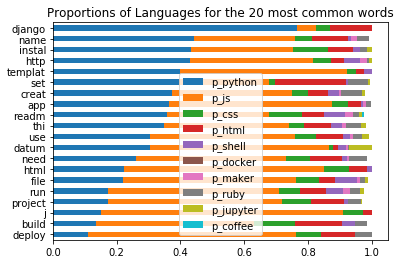

In [33]:
# figure out the percentage of language distribution
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_js=word_counts.js / word_counts['all'],
         p_css=word_counts.css / word_counts['all'],
         p_html=word_counts.html / word_counts['all'],
         p_shell=word_counts.shell / word_counts['all'],
         p_docker=word_counts.docker / word_counts['all'],
         p_maker=word_counts.maker / word_counts['all'],
         p_ruby=word_counts.ruby / word_counts['all'],
         p_jupyter=word_counts.jupyter / word_counts['all'],
         p_coffee=word_counts.coffee / word_counts['all'],
        )
 .sort_values(by='all')
 [['p_python',
   'p_js',
   'p_css',
   'p_html',
   'p_shell',
   'p_docker',
   'p_maker',
   'p_ruby',
   'p_jupyter',
   'p_coffee',
  ]]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportions of Languages for the 20 most common words')

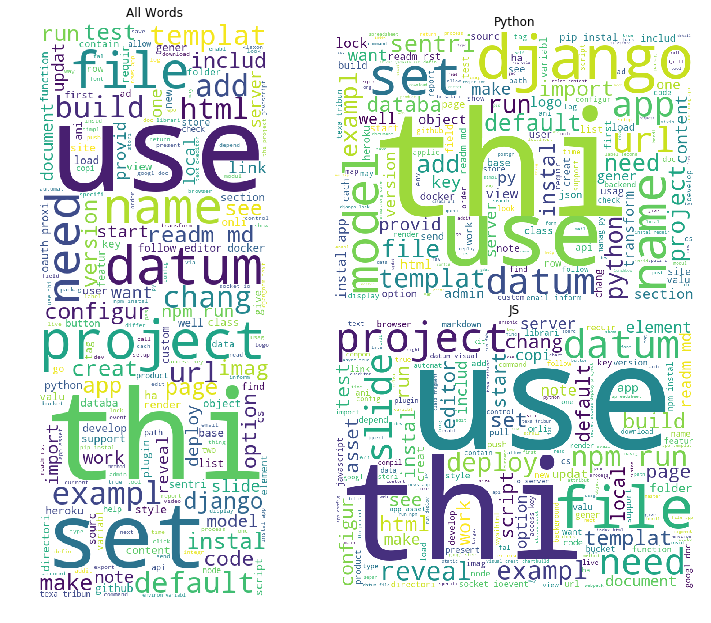

In [37]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))
js_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(python_cloud)
axs[2].imshow(js_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Python')
axs[2].set_title('JS')

for ax in axs: ax.axis('off')

In [38]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(instal, app)    36
(pip, instal)    34
(readm, rst)     32
(readm, md)      30
(like, thi)      25
dtype: int64

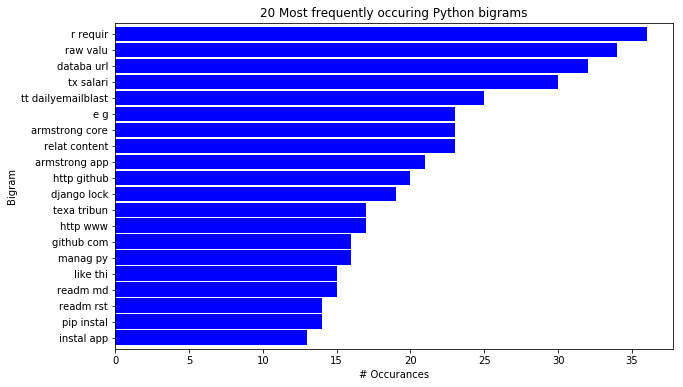

In [39]:
top_20_python_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

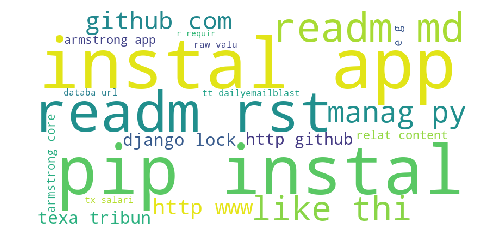

In [40]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [41]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams.head()

(instal, app)    36
(pip, instal)    34
(readm, rst)     32
(readm, md)      30
(like, thi)      25
dtype: int64

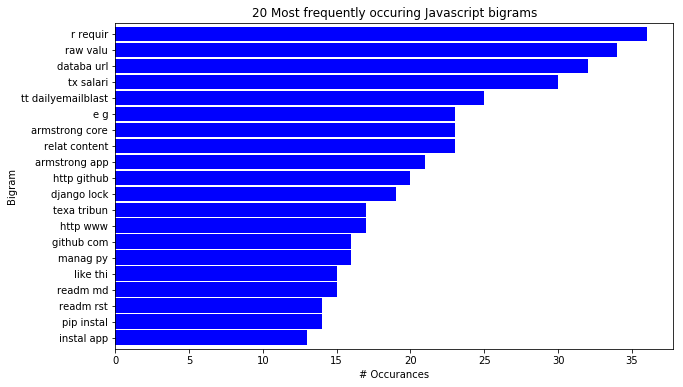

In [42]:
top_20_js_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Javascript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

# MODEL